- CLIP을 활용한 image-to-image search 구축

---

In [20]:
import os
from PIL import Image
import json
import matplotlib.pyplot as plt
import torch
from sklearn.metrics.pairwise import cosine_similarity

---
### prepare model

- zero-shot model : CLIP
- 로컬 cache에 저장된 huggingface 캐쉬 삭제
    - https://huggingface.co/docs/huggingface_hub/main/en/guides/cli
    - pip install -U "huggingface_hub[cli]" 

In [21]:
from transformers import CLIPProcessor, CLIPModel

# https://huggingface.co/

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

- `CLIPModel.from_pretrained`
    - 모델 checkpoint 탐색
    - 모델 weight 다운로드
    - 모델 initialization
    - 모델 meta data 로딩
- `CLIPProcessor.from_pretrained`
    - tokenizer, vocabulary 다운로드

In [22]:
# dir(model)

### data prep

In [23]:
import os

folder = 'art_dataset/drawings/'
image_paths = [os.path.join(folder, i) for i in list(os.walk('art_dataset/drawings/'))[0][2]]

In [24]:
image_paths[2]

'art_dataset/drawings/i - 655.jpeg'

In [25]:
def draw_images(images, texts=['', '', '', '', '']):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    for i in range(5):
        axs[i].imshow(images[i])
        axs[i].axis('off')
        axs[i].text(0.5, -0.1, texts[i], va='bottom', ha='center', fontsize=10, transform=axs[i].transAxes)

    plt.show()

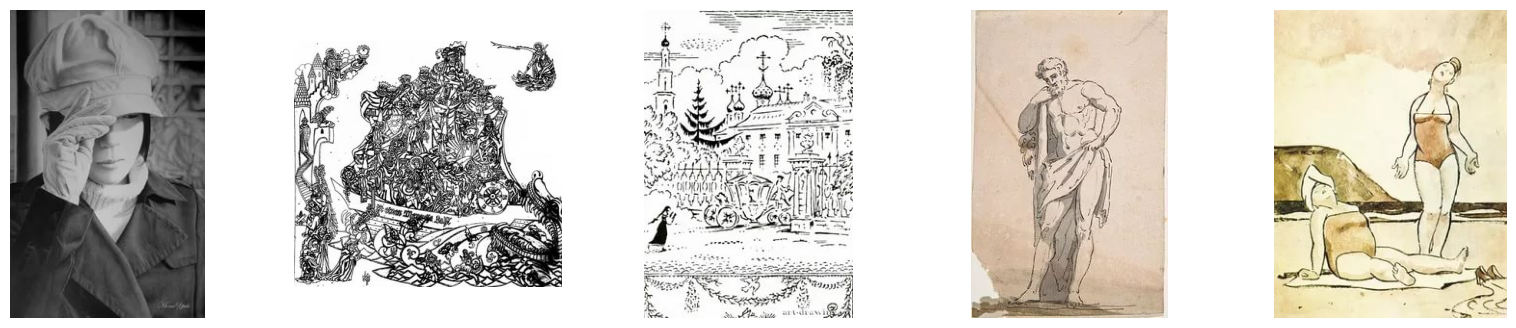

In [26]:
images = [Image.open(i) for i in image_paths[60:65]]
draw_images(images,)

### Image feature extraction
- `model.get_image_features`
- low level features
    - edge, texture
- mid level features
    - low level feature를 종합
    - shapes, patterns (특정 부품 등)
- high level features
    - object type, attribute, context
    - 강아지/고양이, 누워있는/달리는, 배경 등
- Relational and Positional Features
    - 앞/뒤/위/아래
- abstract concepts
    - 텍스트와 이미지를 결합하여 이미지의 추상적인 '느낌'을 인식

In [27]:
def extract_img_features(image_path, processor, model):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt") # pytorch format
    outputs = model.get_image_features(**inputs)
    return outputs.detach()

In [28]:
image_features = [extract_img_features(i, processor, model) for i in image_paths]

In [30]:
len(image_features)

1107

In [31]:
def search_image(query_feature, features, topk=10):
    similarities = cosine_similarity(query_feature, torch.vstack(features)).flatten()
    # sort in descending order
    sorted_indices_desc = similarities.argsort()[::-1]
    # 가장 유사도 높은 이미지는 제외 (query 이미지와 같은 이미지이기 때문)
    topk_indices = sorted_indices_desc[1:topk+1]
    # cosine similarities for the top-k indices
    topk_similarities = similarities[topk_indices]

    return topk_indices, topk_similarities

input image :


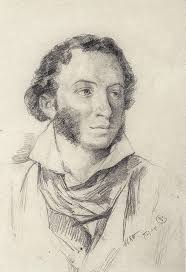

In [40]:
query_id = 10

query_feature = image_features[query_id]
most_similar_idx, distance = search_image(query_feature, image_features)

print("input image :")
Image.open(image_paths[query_id])

In [41]:
# 이미지 읽어오기
similar_images = [Image.open(image_paths[i]) for i in most_similar_idx]

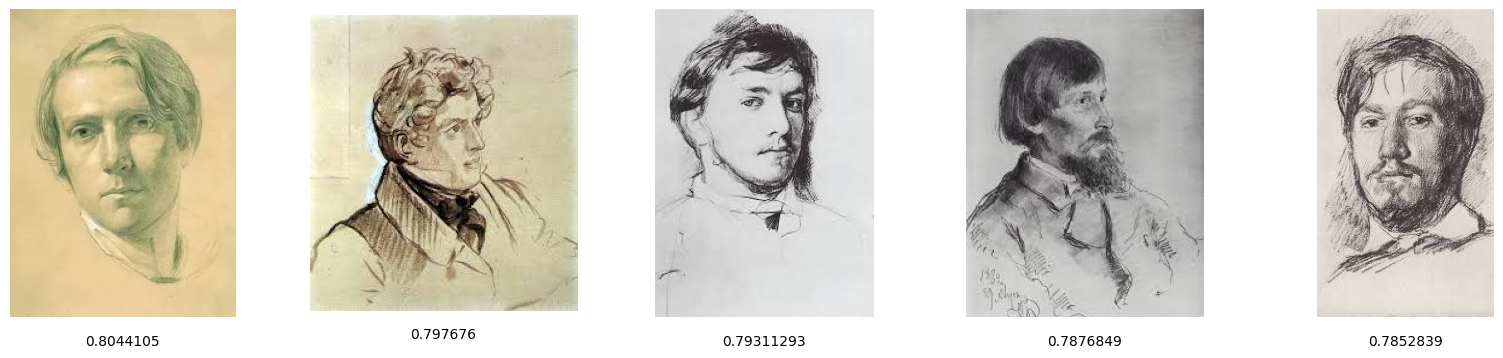

In [42]:
draw_images(similar_images[:5], distance[:5])

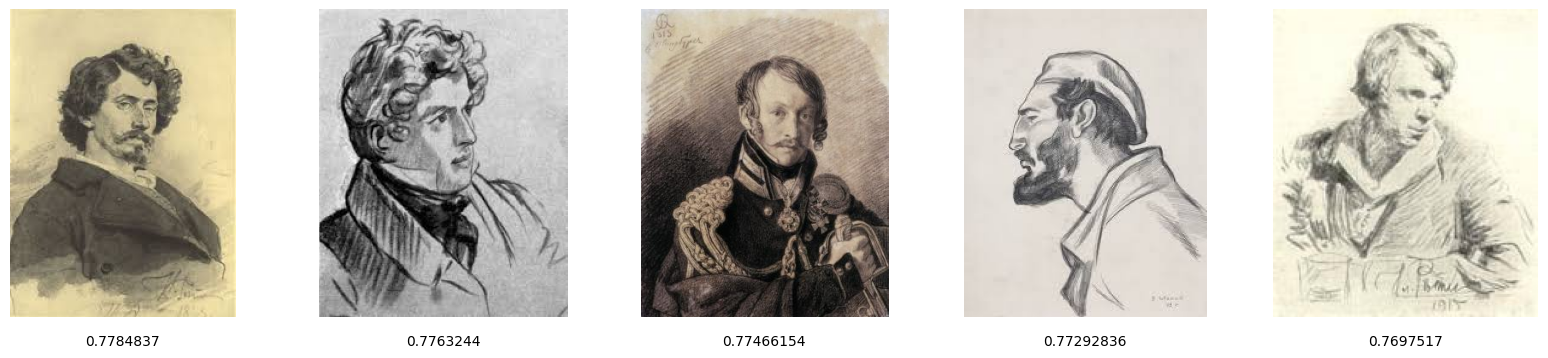

In [43]:
draw_images(similar_images[5:], distance[5:])

### 한계점
- 이미지 내부의 세부적인 디테일을 고려하지 못함

### => 다음 시간에는... Image preprocessing을 통한 detailed search
- Document를 문단/문장으로 나누는 것과 유사
- 이미지에 들어있는 다양한 정보들을 "chunking"하여 개별적으로 저장

--END--